<a href="https://colab.research.google.com/github/VictoorV/Brain_tumor/blob/main/Projet_cancer_du_cerveau.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rm1000/brain-tumor-mri-scans")

print("Path to dataset files:", path)

100%|██████████| 236M/236M [00:08<00:00, 28.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rm1000/brain-tumor-mri-scans/versions/1


In [2]:
pip install torchinfo

In [3]:
pip install timm

# EDA

In [4]:
import os

for category in os.listdir(path):
    category_path = os.path.join(path, category)
    if os.path.isdir(category_path):
        print(f"Catégorie : {category}")
        print(f"Nombre d'images : {len(os.listdir(category_path))}")
        print(f'{"":-<50}')

categories = [cat for cat in os.listdir(path)]
category_paths = {cat : os.path.join(path, cat) for cat in os.listdir(path)}

Catégorie : glioma
Nombre d'images : 1621
--------------------------------------------------
Catégorie : meningioma
Nombre d'images : 1645
--------------------------------------------------
Catégorie : pituitary
Nombre d'images : 1757
--------------------------------------------------
Catégorie : healthy
Nombre d'images : 2000
--------------------------------------------------


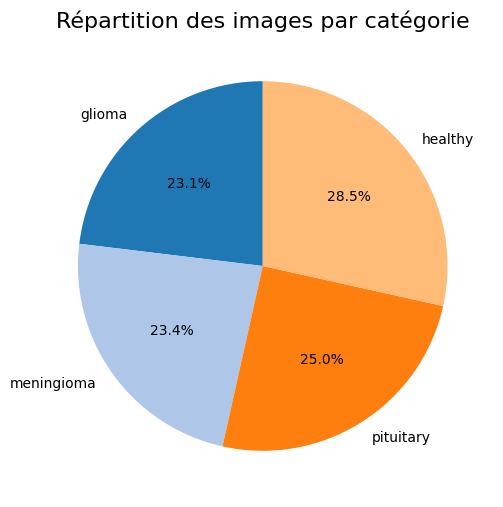

In [5]:
import matplotlib.pyplot as plt

category_counts = {
    cat: len(os.listdir(os.path.join(path, cat)))
    for cat in os.listdir(path)
    if os.path.isdir(os.path.join(path, cat))
}

plt.figure(figsize=(6, 6))
plt.pie(
    category_counts.values(),
    labels=category_counts.keys(),
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.tab20.colors[:len(category_counts)]
)
plt.title("Répartition des images par catégorie", fontsize=16)
plt.show()

La classe 'healthy' est légèrement majoritaire.

In [6]:
from PIL import Image

def show_samples(cat):
  fig, axes = plt.subplots(1, 4, figsize=(18, 6))
  for i in range(0,4):
    sample_image_path = os.path.join(path, cat, os.listdir(category_paths[cat])[i])
    sample_image_path
    image = Image.open(sample_image_path)
    axes[i].imshow(image)
    axes[i].axis("off")
    print(f"Taille de l'image {i+1}:", image.size)
  fig.suptitle(f"Exemples de scans de cerveaux '{cat}'", fontsize=15)
  plt.tight_layout()
  plt.show()

### Glioma

Le gliome infiltrant du tronc cérébral (GITC ou DIPG en anglais pour Diffuse Intrinsec Pontine Glioma) est une tumeur cérébrale maligne très agressive localisée dans une partie du tronc cérébral appelée le pont.

Taille de l'image 1: (512, 512)
Taille de l'image 2: (512, 512)
Taille de l'image 3: (512, 512)
Taille de l'image 4: (512, 512)


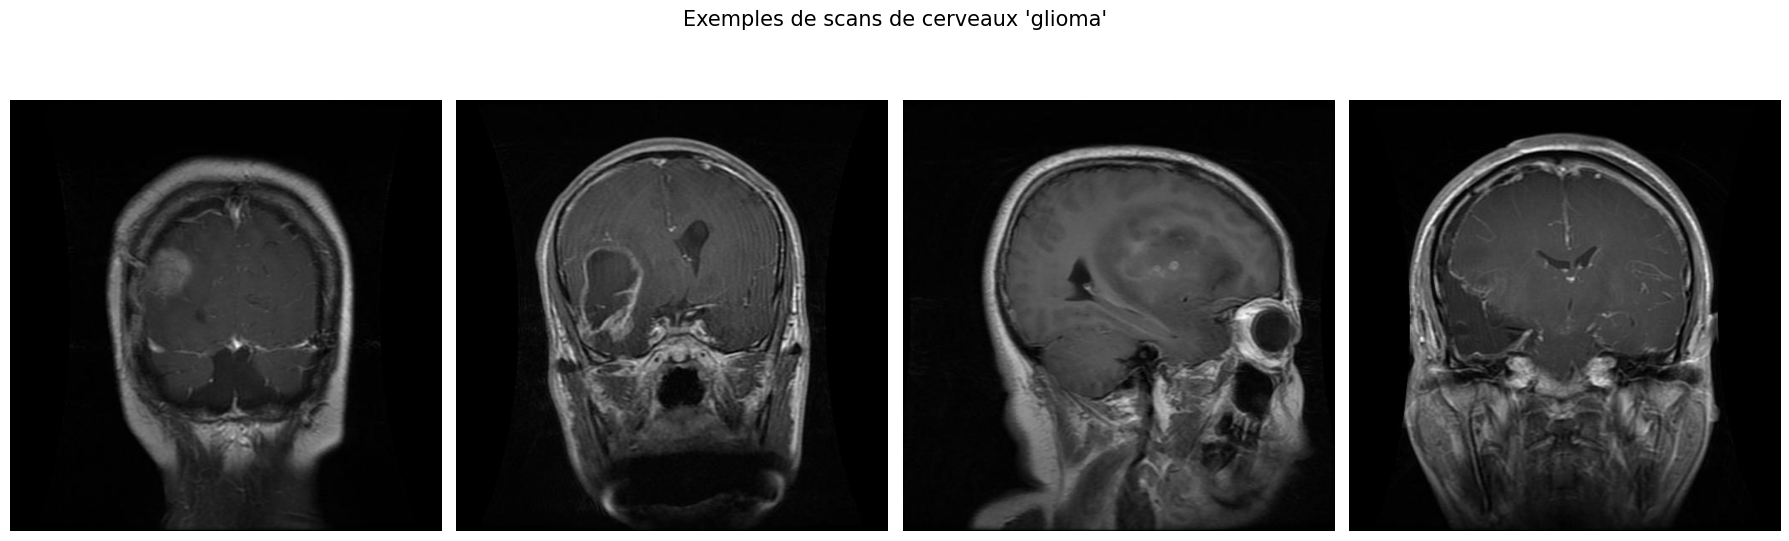

In [7]:
show_samples('glioma')

### Healthy

Catégorie concernant les scans de cerveaux saints.

Taille de l'image 1: (194, 259)
Taille de l'image 2: (300, 168)
Taille de l'image 3: (235, 227)
Taille de l'image 4: (234, 218)


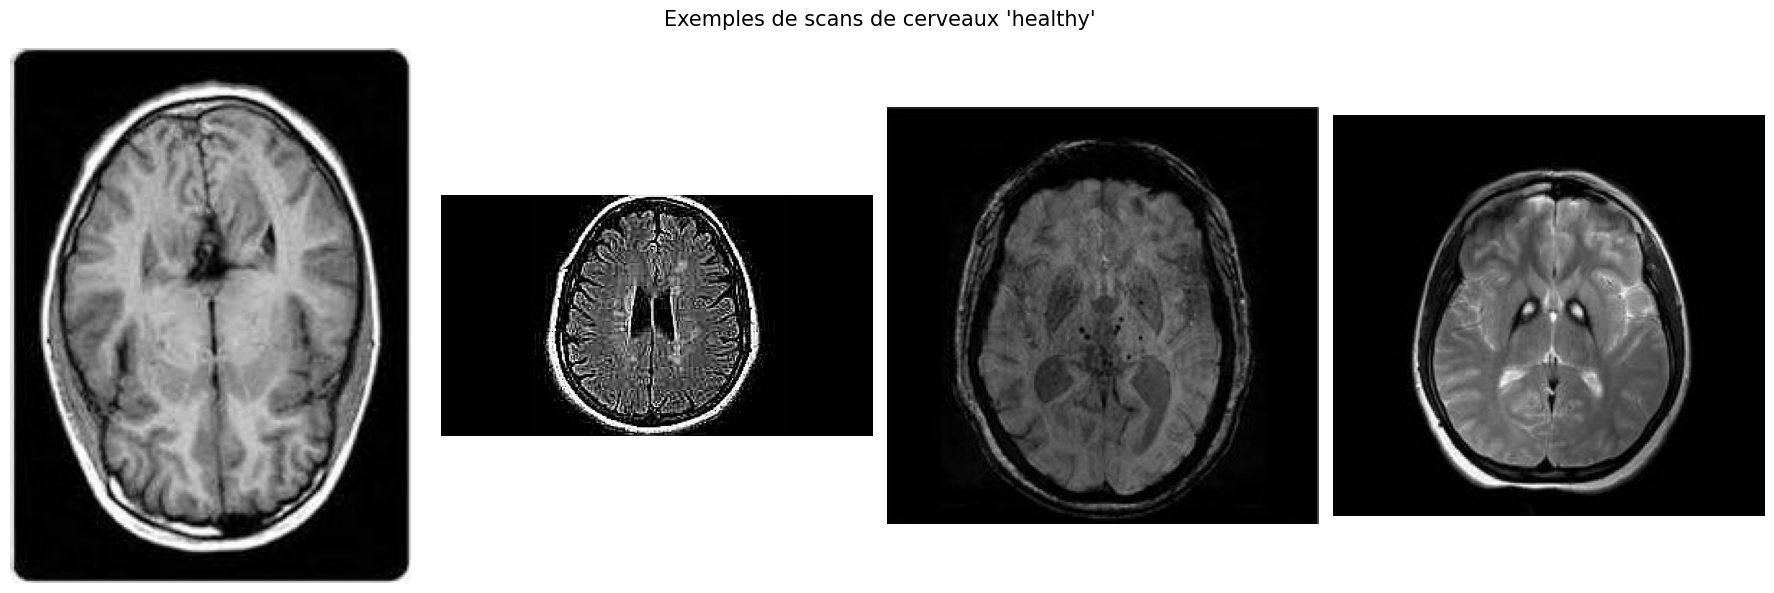

In [8]:
show_samples('healthy')

### Meningioma

Un méningiome est une tumeur cérébrale développée à partir de cellules des enveloppes du cerveau et de la moelle spinale appelées les méninges.

Taille de l'image 1: (512, 512)
Taille de l'image 2: (512, 512)
Taille de l'image 3: (512, 512)
Taille de l'image 4: (512, 512)


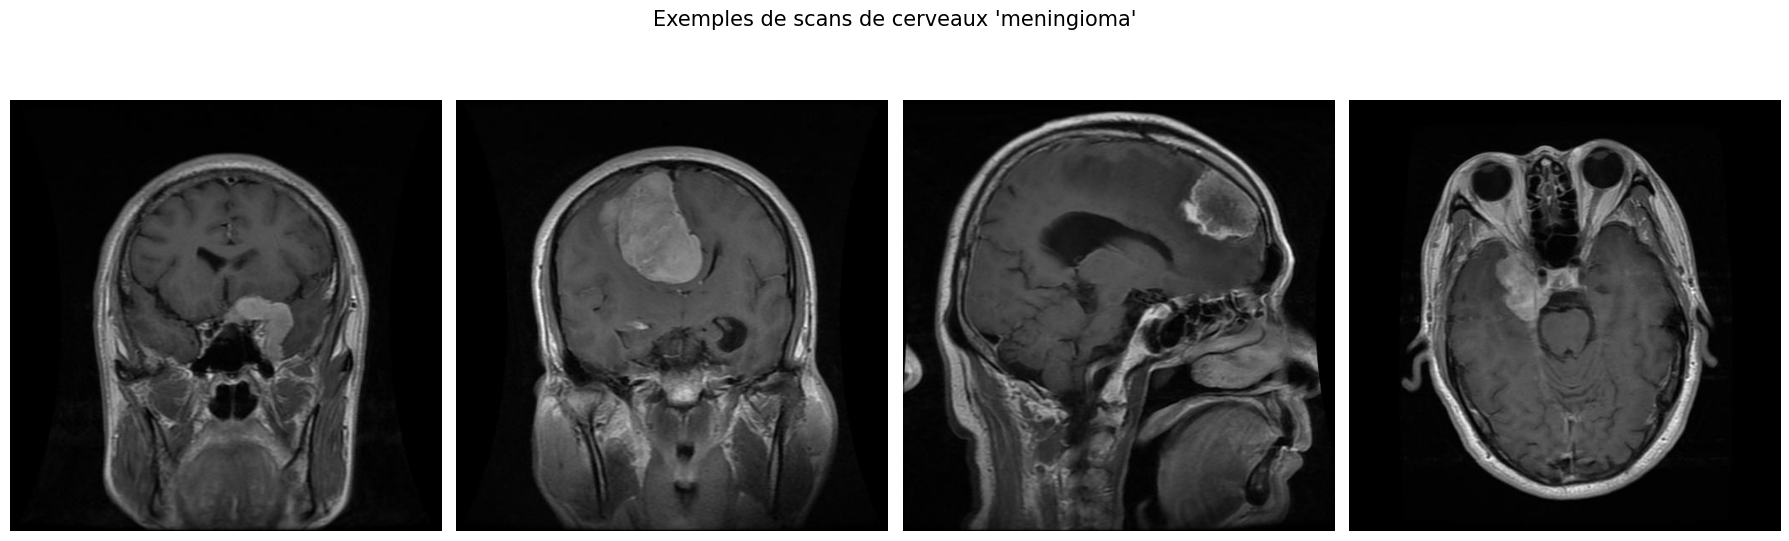

In [9]:
show_samples('meningioma')

### Pituitary

Un adénome hypophysaire est une tumeur cérébrale située dans l'hypophyse.

Taille de l'image 1: (512, 512)
Taille de l'image 2: (512, 512)
Taille de l'image 3: (512, 512)
Taille de l'image 4: (512, 512)


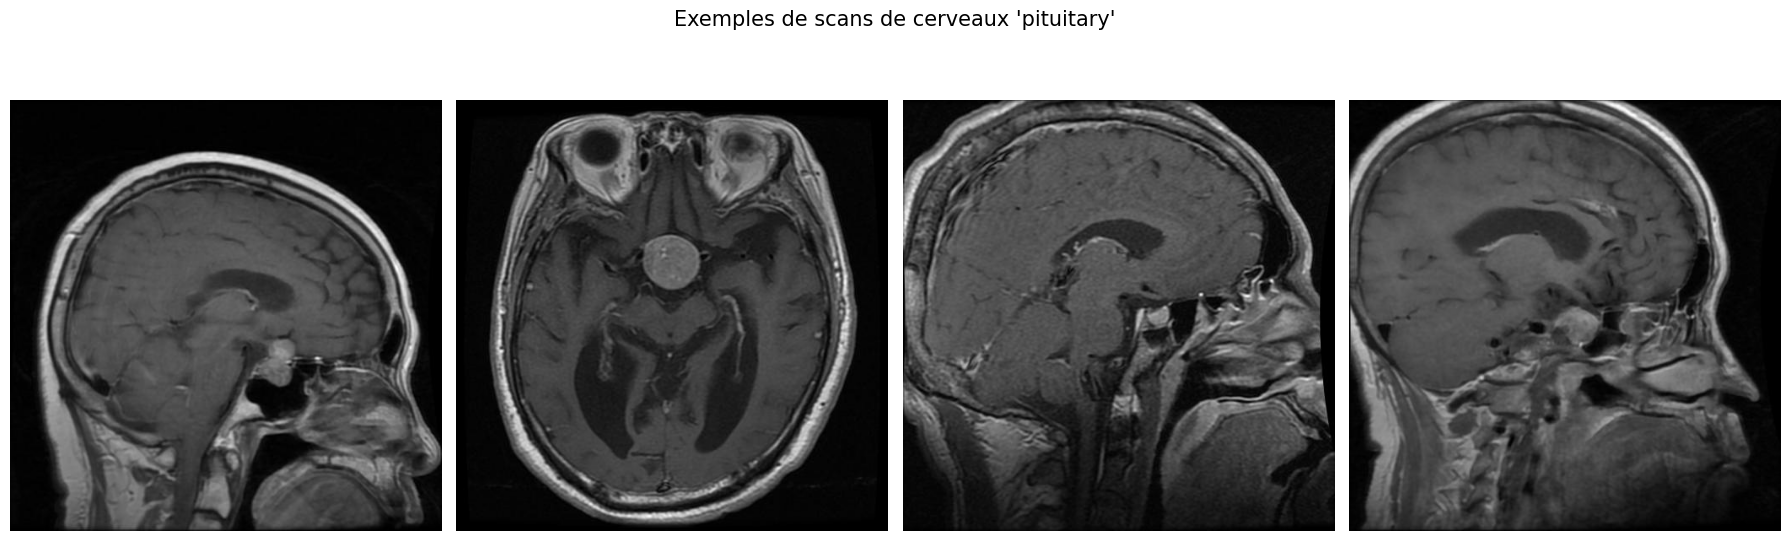

In [10]:
show_samples('pituitary')

# Pre-processing

In [11]:
from torchvision import transforms
from torchvision.transforms import functional as F
from PIL import Image

# Fonction pour ajouter du padding centré
def add_padding(img):
    width, height = img.size
    target_size = max(width, height)

    padding_left = (target_size - width) // 2
    padding_right = target_size - width - padding_left
    padding_top = (target_size - height) // 2
    padding_bottom = target_size - height - padding_top

    return F.pad(img, (padding_left, padding_top, padding_right, padding_bottom), fill=(0, 0, 0))

In [12]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
import torch

torch.manual_seed(2024)
im_size = 384

train_transform = transforms.Compose([
    transforms.Lambda(lambda img: add_padding(img)),
    transforms.Resize((im_size, im_size)),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.3, scale=(0.05, 0.1), ratio=(0.5, 1), value=0),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Lambda(lambda img: add_padding(img)),
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=path)

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size  # 10% pour le test

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Pour que les transformations s'appliquent bien à chaque subdataset
# Dans random_split, chaque sous-ensemble (train_dataset, val_dataset, test_dataset) garde une référence au dataset d'origine, y compris la transformation associée.
# En modifiant la transformation pour un sous-ensemble, cela affecte également tous les autres sous-ensembles.
class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

train_dataset = CustomDataset(train_dataset, transform=train_transform)
val_dataset = CustomDataset(val_dataset, transform=val_test_transform)
test_dataset = CustomDataset(test_dataset, transform=val_test_transform)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Nombre d'images : Train={len(train_dataset)}, Validation={len(val_dataset)}, Test={len(test_dataset)}")


Nombre d'images : Train=5618, Validation=702, Test=703


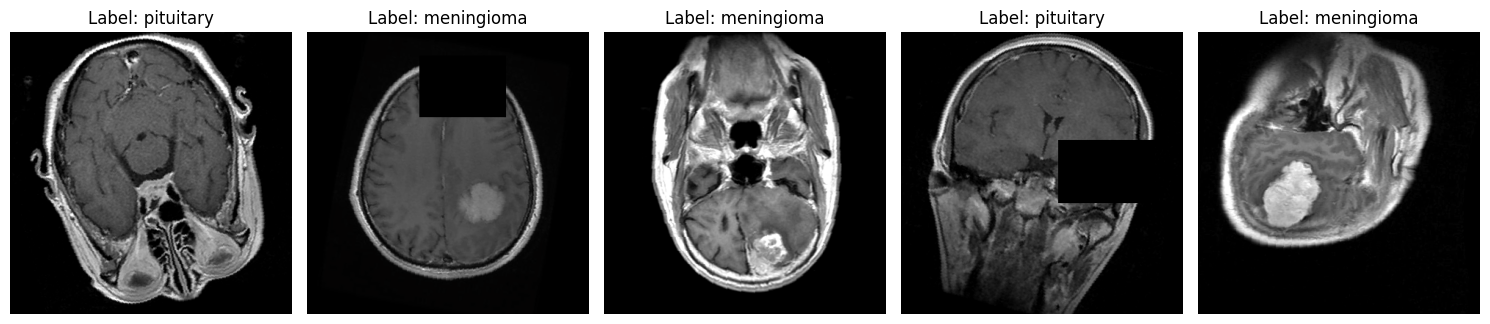

In [13]:
images, labels = next(iter(train_loader))

images = images.numpy()

fig, axes = plt.subplots(1, 5, figsize=(15, 12))
axes = axes.flatten()

for i in range(5):
    ax = axes[i]
    images[i]
    img = images[i]
    img[0] = img[0] * 0.229 + 0.485
    img[1] = img[1] * 0.224 + 0.456
    img[2] = img[2] * 0.225 + 0.406
    img = img.transpose(1, 2, 0)  # Convertir de (C, H, W) à (H, W, C)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Label: {dataset.classes[labels[i].item()]}')

plt.tight_layout()
plt.show()

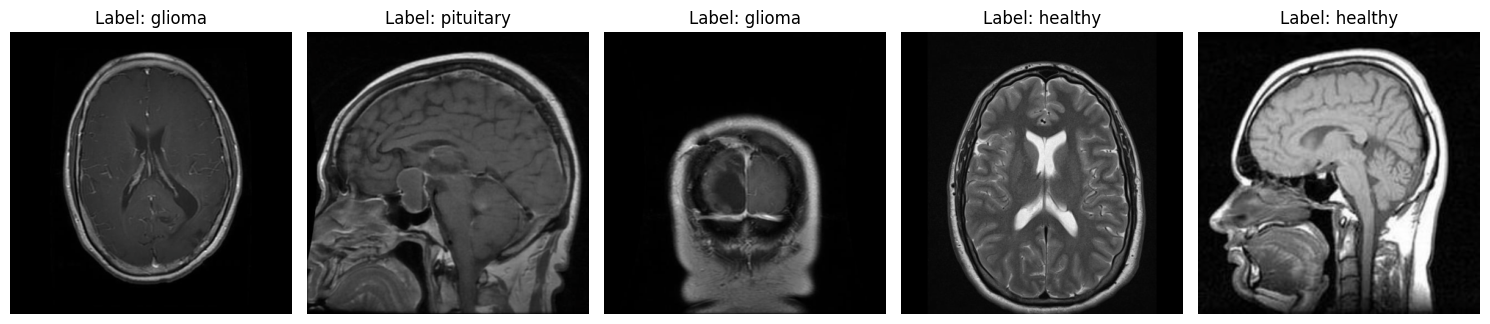

In [14]:
images, labels = next(iter(val_loader))

images = images.numpy()

fig, axes = plt.subplots(1, 5, figsize=(15, 12))
axes = axes.flatten()

for i in range(5):
    ax = axes[i]
    images[i]
    img = images[i]
    img[0] = img[0] * 0.229 + 0.485
    img[1] = img[1] * 0.224 + 0.456
    img[2] = img[2] * 0.225 + 0.406
    img = img.transpose(1, 2, 0)  # Convertir de (C, H, W) à (H, W, C)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Label: {dataset.classes[labels[i].item()]}')

plt.tight_layout()
plt.show()

# Model

In [15]:
import timm

print(timm.list_models(pretrained=True))

['bat_resnext26ts.ch_in1k', 'beit_base_patch16_224.in22k_ft_in22k', 'beit_base_patch16_224.in22k_ft_in22k_in1k', 'beit_base_patch16_384.in22k_ft_in22k_in1k', 'beit_large_patch16_224.in22k_ft_in22k', 'beit_large_patch16_224.in22k_ft_in22k_in1k', 'beit_large_patch16_384.in22k_ft_in22k_in1k', 'beit_large_patch16_512.in22k_ft_in22k_in1k', 'beitv2_base_patch16_224.in1k_ft_in1k', 'beitv2_base_patch16_224.in1k_ft_in22k', 'beitv2_base_patch16_224.in1k_ft_in22k_in1k', 'beitv2_large_patch16_224.in1k_ft_in1k', 'beitv2_large_patch16_224.in1k_ft_in22k', 'beitv2_large_patch16_224.in1k_ft_in22k_in1k', 'botnet26t_256.c1_in1k', 'caformer_b36.sail_in1k', 'caformer_b36.sail_in1k_384', 'caformer_b36.sail_in22k', 'caformer_b36.sail_in22k_ft_in1k', 'caformer_b36.sail_in22k_ft_in1k_384', 'caformer_m36.sail_in1k', 'caformer_m36.sail_in1k_384', 'caformer_m36.sail_in22k', 'caformer_m36.sail_in22k_ft_in1k', 'caformer_m36.sail_in22k_ft_in1k_384', 'caformer_s18.sail_in1k', 'caformer_s18.sail_in1k_384', 'caformer_s

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [17]:
from torchvision import models
from torch import nn, optim

#model = models.convnext_tiny(pretrained=True)  # convnext_tiny   convnext_small   convnext_base
model = timm.create_model('convnextv2_tiny.fcmae_ft_in22k_in1k_384', pretrained=True)
#model = timm.create_model('convnext_tiny.fb_in22k_ft_in1k_384', pretrained=True)
#model = models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

In [18]:
print(model)

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (mlp): GlobalResponseNormMlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (grn): GlobalResponseNorm()
            (fc2): Linear(in_features=384, out_features=96, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), 

In [ ]:
# ConvNeXt (torchvision)
model.classifier[2] = nn.Linear(768,4)

for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

for param in model.features[-1].parameters():
    param.requires_grad = True

In [19]:
# ConvNeXt (V2) timm
model.head.fc = nn.Linear(768,4)

for param in model.parameters():
    param.requires_grad = False

for param in model.head.parameters():
    param.requires_grad = True

for param in model.stages[-1].parameters():
    param.requires_grad = True

In [ ]:
# ResNet50
model.fc = nn.Linear(2048,4)

for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

for param in model.layer4.parameters():
    param.requires_grad = True

In [20]:
from torchinfo import summary

summary(model, input_size=(1, 3, im_size, im_size))

Layer (type:depth-idx)                                       Output Shape              Param #
ConvNeXt                                                     [1, 4]                    --
├─Sequential: 1-1                                            [1, 96, 96, 96]           --
│    └─Conv2d: 2-1                                           [1, 96, 96, 96]           (4,704)
│    └─LayerNorm2d: 2-2                                      [1, 96, 96, 96]           (192)
├─Sequential: 1-2                                            [1, 768, 12, 12]          --
│    └─ConvNeXtStage: 2-3                                    [1, 96, 96, 96]           --
│    │    └─Identity: 3-1                                    [1, 96, 96, 96]           --
│    │    └─Sequential: 3-2                                  [1, 96, 96, 96]           (239,904)
│    └─ConvNeXtStage: 2-4                                    [1, 192, 48, 48]          --
│    │    └─Sequential: 3-3                                  [1, 192, 48, 48]   

In [21]:
from sklearn.utils.class_weight import compute_class_weight

all_labels = []

for i in range(len(train_dataset)):
    all_labels.append(train_dataset[i][1])


all_labels = torch.tensor(all_labels)
classes = torch.unique(all_labels).numpy()

class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=all_labels.numpy())

print("Classes uniques :", classes)
print("Poids des classes :", class_weights)

Classes uniques : [0 1 2 3]
Poids des classes : [1.09726562 0.87891114 1.06401515 0.98908451]


# Train, evaluation functions

In [22]:
def train(model, loader, historical_loss, historical_acc):
  model.train()
  train_loss = 0.0
  correct = 0
  total = 0
  for images, labels in loader:
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (preds == labels).sum().item()

    train_loss+=loss.item()
  train_loss = train_loss/len(loader)
  train_acc = 100 * correct/total
  historical_loss.append(train_loss)
  historical_acc.append(train_acc)

In [23]:
def evaluation(model, loader, historical_loss, historical_acc):
  model.eval()
  eval_loss = 0.0
  correct = 0
  total = 0
  for images, labels in loader:
    with torch.no_grad():
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)

      _, preds = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (preds == labels).sum().item()

      eval_loss+=loss.item()
  eval_loss = eval_loss/len(loader)
  eval_acc = 100 * correct/total
  historical_loss.append(eval_loss)
  historical_acc.append(eval_acc)

# Training loop

In [24]:
model = model.to(device)

In [25]:
#params_to_update = list(model.classifier.parameters())+list(model.features[-1].parameters()) # ConvNeXt
params_to_update = list(model.head.parameters())+list(model.stages[-1].parameters()) # ConvNeXt V2
#params_to_update = list(model.fc.parameters())+list(model.layer4.parameters()) # ResNet50


class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
#optimizer = optim.SGD(params_to_update, lr=1e-3, momentum=0.9, weight_decay=1e-4)
optimizer = optim.AdamW(params_to_update, lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-5)

epochs = 20
training_loss = []
validation_loss = []
training_acc = []
validation_acc = []


In [26]:
for epoch in range(epochs):
  current_lr = scheduler.get_last_lr()[0]
  train(model, train_loader, training_loss, training_acc)
  evaluation(model, val_loader, validation_loss, validation_acc)
  print(f"Epoch [{epoch+1}/{epochs}]".center(50, "-"))
  print(f"{'Metric':<20}{'Training':<15}{'Validation':<15}")
  print(f"{'Loss':<20}{training_loss[-1]:<15.4f}{validation_loss[-1]:<15.4f}")
  print(f"{'Accuracy':<20}{training_acc[-1]:<15.4f}{validation_acc[-1]:<15.4f}")
  print(f"{'Learning Rate':<20}{current_lr:.6f}")
  print(f"{'-' * 50}")
  scheduler.step()

  model_name =  str(epoch+1) + "_" + model.__class__.__name__+ "_" + str(im_size) + ".pth"
  torch.save(model.state_dict(), model_name)
  print(f"Saving {model_name}")
  print("")

-------------------Epoch [1/20]-------------------
Metric              Training       Validation     
Loss                0.5681         0.3239         
Accuracy            77.6967        87.3219        
Learning Rate       0.001000
--------------------------------------------------
Saving 1_ConvNeXt_384.pth

-------------------Epoch [2/20]-------------------
Metric              Training       Validation     
Loss                0.1906         0.1295         
Accuracy            93.0046        95.1567        
Learning Rate       0.000994
--------------------------------------------------
Saving 2_ConvNeXt_384.pth

-------------------Epoch [3/20]-------------------
Metric              Training       Validation     
Loss                0.1128         0.1176         
Accuracy            95.9416        96.1538        
Learning Rate       0.000976
--------------------------------------------------
Saving 3_ConvNeXt_384.pth

-------------------Epoch [4/20]-------------------
Metric          

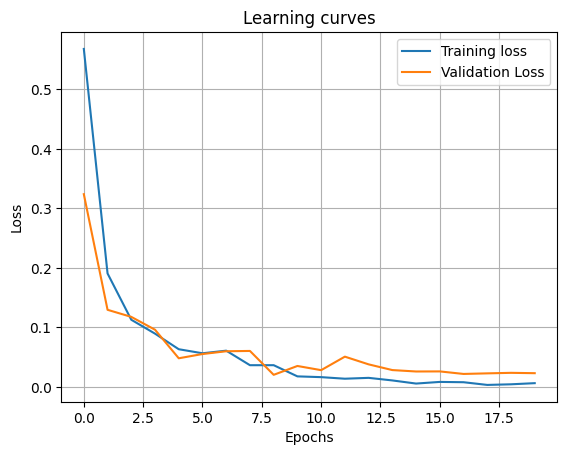

In [27]:
plt.plot(training_loss, label='Training loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Learning curves")
plt.grid()
plt.legend()
plt.show()

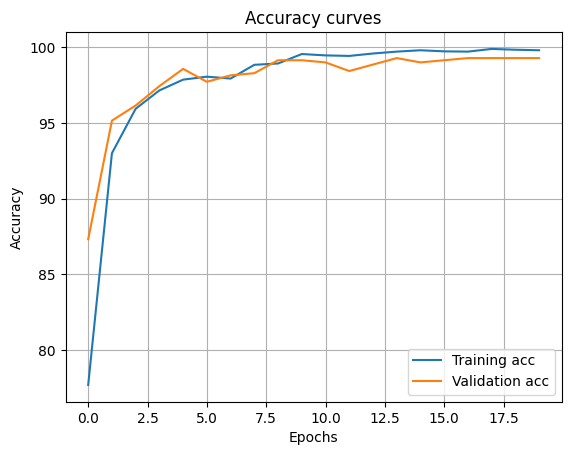

In [58]:
plt.plot(training_acc, label='Training acc')
plt.plot(validation_acc, label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy curves")
plt.grid()
plt.legend()
plt.show()

In [44]:
model.load_state_dict(torch.load('20_ConvNeXt_384.pth'))

<ipython-input-44-6fc52bf34076>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('18_ConvNeXt_384.pth'))


<All keys matched successfully>

In [33]:
weights_to_save = {
    "head": model.head.state_dict(),
    "stages_last_layer": model.stages[-1].state_dict(),
}

torch.save(weights_to_save, "ConvNeXtV2_384_weights.pth")
print("Modèle sauvegardé sur Colab.")

Modèle sauvegardé sur Colab.


In [35]:
from google.colab import files

files.download('ConvNeXtV2_384_weights.pth')
print("Modèle sauvegardé en local.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Modèle sauvegardé en local.


In [48]:
# Charger les poids
weights = torch.load("./ConvNeXtV2_384_weights.pth")

model.stages[-1].load_state_dict(weights["stages_last_layer"])
model.head.load_state_dict(weights["head"])

<ipython-input-48-4acd5f564921>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load("./ConvNeXtV2_384_weights.pth")


<All keys matched successfully>

In [54]:
from sklearn.metrics import classification_report
label_true = []
label_pred = []
probas_list = []

images_list = []  # Pour stocker les images à afficher
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs, pred_labs = torch.max(torch.softmax(outputs, dim=1), dim=1)

        probas_list.extend(probs.cpu().numpy())
        label_true.extend(labels.cpu().numpy())
        label_pred.extend(pred_labs.cpu().numpy())

        images_list.extend(images.cpu().numpy())

In [55]:
print(classification_report(label_true,label_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       169
           1       0.99      1.00      1.00       198
           2       0.99      0.99      0.99       164
           3       1.00      0.99      0.99       172

    accuracy                           0.99       703
   macro avg       0.99      0.99      0.99       703
weighted avg       0.99      0.99      0.99       703



<Axes: >

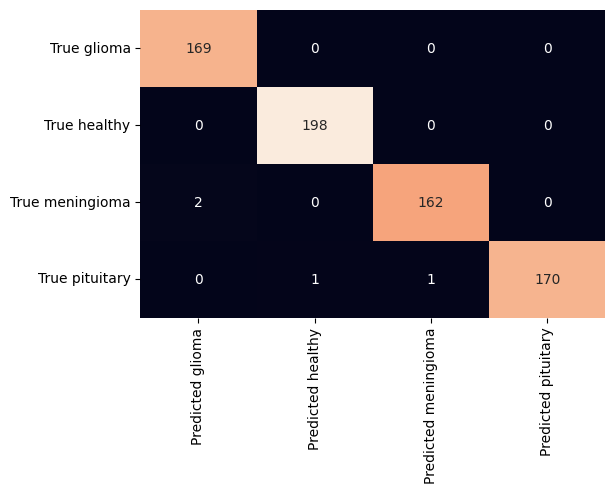

In [56]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(label_true, label_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cbar=False,
                xticklabels=['Predicted glioma', 'Predicted healthy', 'Predicted meningioma', 'Predicted pituitary'],
                yticklabels=['True glioma', 'True healthy', 'True meningioma', 'True pituitary'])

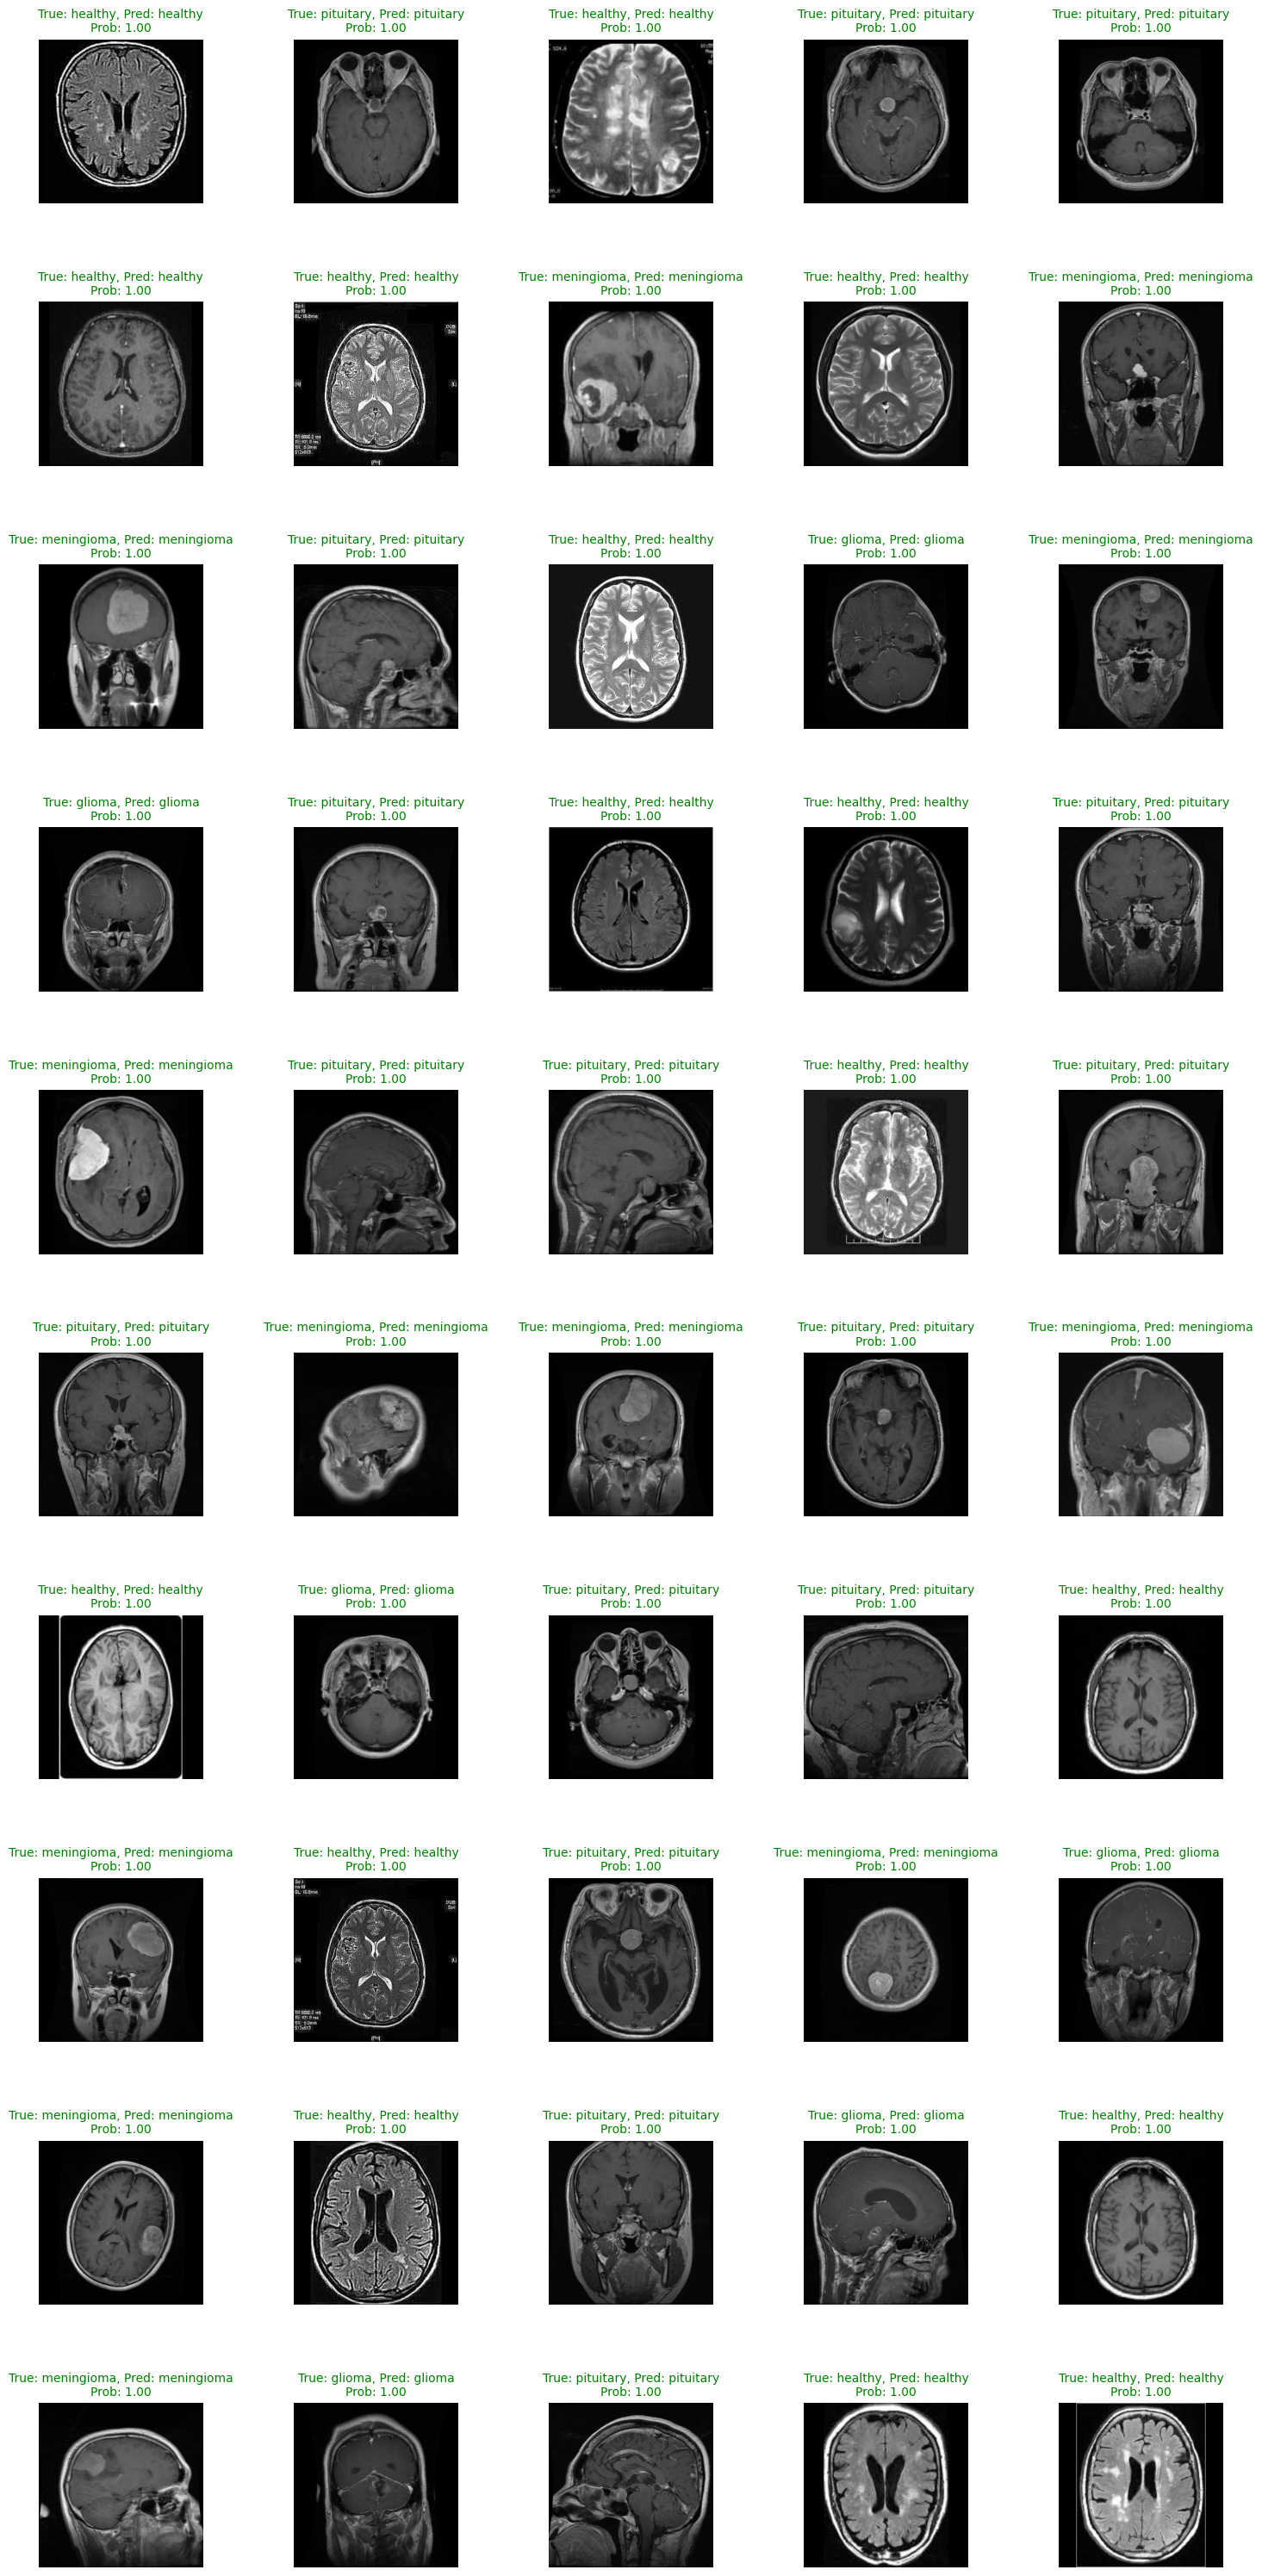

In [57]:
import numpy as np
def denormalize(tensor, mean, std):
    """
    Inverse la normalisation des images.
    Attend un tenseur au format (C, H, W).
    """
    mean = np.array(mean).reshape(3, 1, 1)  # Reshape pour correspondre à (C, 1, 1)
    std = np.array(std).reshape(3, 1, 1)    # Reshape pour correspondre à (C, 1, 1)
    tensor = std * tensor + mean            # Dénormalisation

    tensor = tensor.transpose((1, 2, 0))    # Retour au format (H, W, C) pour Matplotlib
    return np.clip(tensor, 0, 1)

def show_images_with_predictions(images_list, labels_true, labels_pred, probas, mean, std, num_images):
    """
    Affiche des images avec les étiquettes vraies, les prédictions et les probabilités.
    """
    num_images = min(num_images, len(images_list))
    rows = (num_images + 4) // 5
    fig, axes = plt.subplots(rows, 5, figsize=(15, 3 * rows))

    for i in range(num_images):
        img = images_list[i]
        true_label = labels_true[i]
        pred_label = labels_pred[i]
        proba = probas[i]

        denormalized_img = denormalize(img, mean, std)

        ax = axes[i // 5, i % 5] if rows > 1 else axes[i % 5]
        ax.imshow(denormalized_img)
        ax.axis('off')

        title_color = 'green' if true_label == pred_label else 'red'

        ax.set_title(
            f"True: {dataset.classes[true_label]}, Pred: {dataset.classes[pred_label]}\nProb: {proba:.2f}",
            fontsize=10, color=title_color
        )

    for j in range(num_images, rows * 5):
        ax = axes[j // 5, j % 5] if rows > 1 else axes[j % 5]
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.6)
    plt.show()

num_images = 50
show_images_with_predictions(
    images_list=images_list[:num_images],
    labels_true=label_true[:num_images],
    labels_pred=label_pred[:num_images],
    probas=probas_list[:num_images],
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225],
    num_images=num_images)